In [ ]:
from IPython.display import display, Javascript

# Auto-save every 5 minutes
display(Javascript('''
    IPython.notebook.save_checkpoint();
    setInterval(function() {
        IPython.notebook.save_checkpoint();
        console.log("Auto-saved notebook at " + new Date().toLocaleTimeString());
    }, 300000);
'''))

<IPython.core.display.Javascript object>

In [2]:
import selfies as sf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from collections import Counter
import torch
from torch.utils.data import Dataset
import torch.nn as nn
from tensorflow.keras.preprocessing.sequence import pad_sequences
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch.nn as nn

from cddd.inference import InferenceModel
from cddd.preprocessing import preprocess_smiles
from scipy.ndimage import gaussian_filter

# Smiles to Embedding via cddd

In [3]:
import os
import csv
import pandas as pd
import numpy as np

# import and preprocess dataset

input_csv = "computed_spectra.csv"
output_csv = "spectra_and_embeddings_full.csv"
row_num = 0

# create an instance of the model
inference_model = InferenceModel()
print("created model")


created model


In [4]:

# skip preprocessing if file already exists
if os.path.exists(output_csv):
    print(f"{output_csv} already exists. loading data... ")

    df = pd.read_csv(output_csv)
    smiles_list = df["smiles"].tolist() # FIX

    spectra_array = df.iloc[:, 1:1802].values   # spectra columns
    embedded_smiles = df.iloc[:, 1802:].values  # embedded SMILES columns

    print("spectra shape: ", spectra_array.shape)
    print("embedded smiles shape: ", embedded_smiles.shape)

else:
    print("Processing raw SMILES and spectra...")

    smiles_list = []
    spectra_list = []

    with open(input_csv, "r") as f:
        total_rows = sum(1 for _ in f) - 1  # minus 1 for header

    with open(input_csv, "r") as f:
        reader = csv.reader(f)
        header = next(reader)  # e.g., ["smiles", "spectrum_0", ..., "spectrum_1800"]
        for row in reader:
            row_num += 1
            if row_num % 1000 == 0:
                print(f"Processed {row_num}/{total_rows}")
            smiles = row[0].strip()
            spectrum = [float(val) for val in row[1:]]
            try:
                smiles_list.append(smiles)
                spectra_list.append(spectrum)
            except:
                continue

    spectra_array = np.array(spectra_list)  # shape (N, 1801)


    # encode all SMILES into the continuous embedding --> size 512
    print("encoding SMILES...")
    embedded_smiles = inference_model.seq_to_emb(smiles_list)  # shape (N, 512)
    print("embedding shape:", embedded_smiles.shape)

    # combine all data: smiles + spectra + embeddings
    combined_array = np.hstack((np.array(smiles_list).reshape(-1, 1), spectra_array, embedded_smiles))

    # create headers
    spectra_headers = [f"spectrum_{i}" for i in range(spectra_array.shape[1])]
    embed_headers = [f"emb_{i}" for i in range(embedded_smiles.shape[1])]
    headers = ["smiles"] + spectra_headers + embed_headers

    # create DataFrame and save
    combined_df = pd.DataFrame(combined_array, columns=headers)
    combined_df.to_csv(output_csv, index=False)
    print(f"saved new file: {output_csv}")


spectra_and_embeddings_full.csv already exists. loading data... 
spectra shape:  (85506, 1801)
embedded smiles shape:  (85506, 512)


In [5]:
'''
# create a smiles list of 6000
smiles_list = []

with open("computed_spectra.csv", "r") as f:
    reader = csv.reader(f)
    next(reader)  # skip header line
    for i, row in enumerate(reader):
        if i >= 6000:
            break
        smiles = row[0].strip()
        try:
            smiles_list.append(smiles)
        except:
            continue

# make instance of autoencoder model
inference_model = InferenceModel(model_dir="cddd/data/default_model")

# embed the smiles
# get 512-dim CDDD embeddings
smiles_embedding = inference_model.seq_to_emb(smiles_list)


# print example to see if it works
for i in range(5):
    print(f"SMILES: {smiles_list[i]}") # full smiles
    print(f"Embedding: {smiles_embedding[i][:10]}...\n")  # print first 10 values of the embedding

'''

'\n# create a smiles list of 6000\nsmiles_list = []\n\nwith open("computed_spectra.csv", "r") as f:\n    reader = csv.reader(f)\n    next(reader)  # skip header line\n    for i, row in enumerate(reader):\n        if i >= 6000:\n            break\n        smiles = row[0].strip()\n        try:\n            smiles_list.append(smiles)\n        except:\n            continue\n\n# make instance of autoencoder model\ninference_model = InferenceModel(model_dir="cddd/data/default_model")\n\n# embed the smiles\n# get 512-dim CDDD embeddings\nsmiles_embedding = inference_model.seq_to_emb(smiles_list)\n\n\n# print example to see if it works\nfor i in range(5):\n    print(f"SMILES: {smiles_list[i]}") # full smiles\n    print(f"Embedding: {smiles_embedding[i][:10]}...\n")  # print first 10 values of the embedding\n\n'

# Normalize Spectra 

In [6]:
import numpy as np
import csv
from sklearn.preprocessing import MinMaxScaler

spec_len = 1801
spectra_list = []

# Load spectra from CSV
with open("computed_spectra.csv", "r") as f:
    reader = csv.reader(f)
    next(reader)  # skip header
    for i, row in enumerate(reader):
        #if i >= 6000:
            #break
        try:
            spectrum = [float(x) for x in row[1:]]
            if len(spectrum) == spec_len:
                spectra_list.append(spectrum)
        except:
            continue

# convert to np array
spectra_array = np.array(spectra_list)

# normalize using minmax scaling
scaler = MinMaxScaler()
normalized_spectra = scaler.fit_transform(spectra_array)

# the input for the model
X = normalized_spectra

# check if it worked :)))
print("Normalized spectra shape:", X.shape)
print("Sample normalized spectrum:", X[0][:10])


Normalized spectra shape: (85506, 1801)
Sample normalized spectrum: [0.0086403  0.00853724 0.00871799 0.00868892 0.00868103 0.00868275
 0.00859874 0.00842945 0.00839367 0.00825264]


# Train/Test Split 

In [7]:
from sklearn.model_selection import train_test_split

# set up X and Y
X = np.array(normalized_spectra)
Y = np.array(embedded_smiles)

# fit to right length
min_len = min(len(X), len(Y))
X = X[:min_len]
Y = Y[:min_len]

# debug rqqq
print(f" shape: {X.shape}, Y shape: {Y.shape}")


# train and temp split (val+test)
X_train, X_temp, Y_train, Y_temp, smiles_train, smiles_temp = train_test_split(X, Y, smiles_list, test_size=0.3, random_state=42)

# temp split into test and val
X_val, X_test, Y_val, Y_test, smiles_val, smiles_test = train_test_split(
    X_temp, Y_temp, smiles_temp, test_size=0.5, random_state=42
)

print("Train size:", len(X_train), "Test size:", len(X_test), "Val size:", len(X_val))


 shape: (85506, 1801), Y shape: (85506, 512)
Train size: 59854 Test size: 12826 Val size: 12826


# Dataset and Dataloaders

In [8]:
import torch
from torch.utils.data import Dataset, DataLoader

class SpectraToSMILESDataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

# wrap train/test sets
train_dataset = SpectraToSMILESDataset(X_train, Y_train)
test_dataset = SpectraToSMILESDataset(X_test, Y_test)
val_dataset = SpectraToSMILESDataset(X_val, Y_val)

# loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)
val_loader = DataLoader(val_dataset, batch_size=64)



# Model

In [9]:
import torch.nn as nn

class SpectraToEmbedding(nn.Module):
    def __init__(self, input_dim=1801, output_dim=512, hidden_dim=1024):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),

            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),

            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.model(x)

model = SpectraToEmbedding()


# Train 2nd Model

In [10]:
'''
import torch
import torch.nn.functional as F

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Scheduler (optional but helpful for long training)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=5, verbose=True)

test_losses = []
train_losses = []
# Hybrid loss function (MSE + Cosine)
def hybrid_loss(y_pred, y_true):
    mse = F.mse_loss(y_pred, y_true)
    cos = 1 - F.cosine_similarity(y_pred, y_true, dim=1).mean()
    return 0.5 * mse + 0.5 * cos

# Training loop
num_epochs = 200
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for X_batch, Y_batch in train_loader:
        X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
        optimizer.zero_grad()
        Y_pred = model(X_batch)

        loss = hybrid_loss(Y_pred, Y_batch)

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    train_losses.append(total_loss)

    avg_loss = total_loss / len(train_loader)
    scheduler.step(avg_loss)
    #print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X_batch, Y_batch in test_loader:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            Y_pred = model(X_batch)
            test_loss += hybrid_loss(Y_pred, Y_batch)

    test_losses.append(test_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss = {total_loss:.4f}, Test Loss = {test_loss:.4f}")
    #print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

'''

'\nimport torch\nimport torch.nn.functional as F\n\n# Optimizer\noptimizer = torch.optim.Adam(model.parameters(), lr=1e-3)\n\n# Scheduler (optional but helpful for long training)\nscheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=5, verbose=True)\n\ntest_losses = []\ntrain_losses = []\n# Hybrid loss function (MSE + Cosine)\ndef hybrid_loss(y_pred, y_true):\n    mse = F.mse_loss(y_pred, y_true)\n    cos = 1 - F.cosine_similarity(y_pred, y_true, dim=1).mean()\n    return 0.5 * mse + 0.5 * cos\n\n# Training loop\nnum_epochs = 200\nfor epoch in range(num_epochs):\n    model.train()\n    total_loss = 0\n    for X_batch, Y_batch in train_loader:\n        X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)\n        optimizer.zero_grad()\n        Y_pred = model(X_batch)\n\n        loss = hybrid_loss(Y_pred, Y_batch)\n\n        loss.backward()\n        optimizer.step()\n        total_loss += loss.item()\n\n    train_losses.append(total_loss)\n\n    avg

# Train za Model

In [11]:
# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# scheduler: reduce LR by factor=0.5 if no improvement in 5 epochs
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

# loss function
loss_fn = nn.CosineEmbeddingLoss()

# to track losses
train_losses = []
test_losses = []
val_losses = []


# early stopping params
best_loss = float('inf')
patience = 10
wait = 0
best_model_state = None

# Training loop
num_epochs = 200
for epoch in range(num_epochs):
    model.train()
    train_loss = 0

    for X_batch, Y_batch in train_loader:
        optimizer.zero_grad()
        Y_pred = model(X_batch)

        target = torch.ones(X_batch.size(0)).to(X_batch.device)
        loss = loss_fn(Y_pred, Y_batch, target)

        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_losses.append(train_loss)

    # validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, Y_batch in val_loader:
            Y_pred = model(X_batch)
            target = torch.ones(X_batch.size(0)).to(X_batch.device)
            val_loss += loss_fn(Y_pred, Y_batch, target).item()

    val_losses.append(val_loss)

    scheduler.step(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")

    # Early stopping check
    if val_loss < best_loss - 1e-4:
        best_loss = val_loss
        wait = 0
        best_model_state = model.state_dict()
    else:
        wait += 1
        if wait >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

# Load best model
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print("Best model restored.")




Epoch 1/200, Train Loss = 322.3222, Val Loss = 60.2141
Epoch 2/200, Train Loss = 279.9213, Val Loss = 59.9237
Epoch 3/200, Train Loss = 267.3234, Val Loss = 55.4378
Epoch 4/200, Train Loss = 259.6148, Val Loss = 53.3432
Epoch 5/200, Train Loss = 253.8676, Val Loss = 53.1345
Epoch 6/200, Train Loss = 248.6898, Val Loss = 51.6512
Epoch 7/200, Train Loss = 244.2138, Val Loss = 53.7273
Epoch 8/200, Train Loss = 241.6224, Val Loss = 50.8200
Epoch 9/200, Train Loss = 239.5758, Val Loss = 49.8179
Epoch 10/200, Train Loss = 236.6266, Val Loss = 49.4744
Epoch 11/200, Train Loss = 235.1170, Val Loss = 49.5125
Epoch 12/200, Train Loss = 234.5315, Val Loss = 48.6236
Epoch 13/200, Train Loss = 230.7206, Val Loss = 49.7103
Epoch 14/200, Train Loss = 231.0629, Val Loss = 48.9540
Epoch 15/200, Train Loss = 229.9071, Val Loss = 51.0349
Epoch 16/200, Train Loss = 225.9406, Val Loss = 47.4062
Epoch 17/200, Train Loss = 226.9299, Val Loss = 50.0303
Epoch 18/200, Train Loss = 224.5196, Val Loss = 48.4797
E

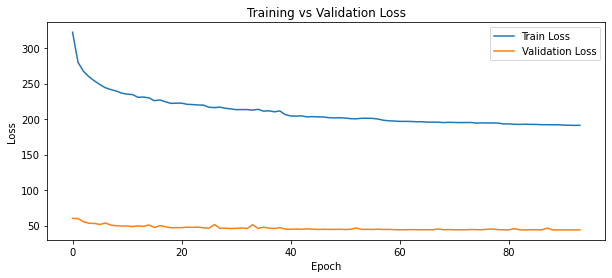

In [12]:
# plot loss graph
plt.figure(figsize=(10, 4))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()

# Eval

In [ ]:
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

# Set model to evaluation mode
model.eval()
predicted_embeddings = []
test_losses = []
test_loss = 0

# Collect predicted embeddings from test set
with torch.no_grad():
    for X_batch, _ in test_loader:
        pred = model(X_batch)
        target = torch.ones(X_batch.size(0)).to(X_batch.device)
        test_loss += loss_fn(pred, _, target).item()
        predicted_embeddings.append(pred)
    test_losses.append(test_loss)

print(f"Final Test Loss: {test_loss:.4f}")

# Decode embeddings
#predicted_embeddings = torch.cat(predicted_embeddings, dim=0).cpu().numpy()

# Decode using CDDD inference model
print("Decoding predictions...")
#decoded_smiles = inference_model.emb_to_seq(predicted_embeddings)

# Print every 100th decoded SMILES
for i, smiles in enumerate(decoded_smiles):
    if i % 100 == 0:
        print(f"[{i}] {smiles}")

Final Test Loss: 43.9260
Decoding predictions...
INFO:tensorflow:Restoring parameters from /home/undergrad/2026/wcarvalh/Documents/uvsq/cddd/cddd/data/default_model/model.ckpt


In [14]:
# Store as list of lists
embedding_lists = [row.tolist() for row in predicted_embeddings]

df = pd.DataFrame({
    "True_SMILES": smiles_test,
    "Predicted_Emb": embedding_lists
})

# Save as pickle (recommended for Python-only workflows)
df.to_pickle("unprocessed_predictions.pkl")


In [7]:
import csv
import os

output_path = "decoded_predictions.csv"

print(len(pd.read_csv("decoded_predictions.csv")))
existing_df = pd.read_csv(output_path)

existing_df


14652


,True_SMILES,Pred_SMILES
0,CC1(C)C=C(CO)c2cc3c(c4c2N1CCC4)Oc1c2c4c(cc1=C3...,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...
1,COc1ccc2sc(N(C)C)c(C(=O)c3ccc(OCCN4CCCCC4)cc3)...,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...
2,OCc1c(F)c(F)c(F)c(F)c1F,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
3,CNc1cccc(C(=O)C(C)(C)C)c1,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...
4,O=c1[nH]ccc2nn(C3CCNCC3)c(Nc3ccnc(F)c3)c12,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...
...,...,...
14647,O=C(C(=O)N1CCCCCC1)N(CCO)CCO,O=============================================...
14648,CCOC(=O)c1ccc(NC(=O)c2cc(-c3ccccc3)n(C)n2)cc1,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...
14649,C=CCS(=O)C[C@H](N)C(=O)O,CN[[[[[[[[N[[[[S[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[...
14650,O=C(c1ccc2cc[nH]c2c1)N1CCC2(CC(Oc3cccnc3)CO2)C1,OOCCOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...


In [4]:
import os
import time
import pandas as pd
import numpy as np

output_path = "decoded_predictions.csv"

# Check how many rows are already saved (if any)
if os.path.exists(output_path):
    existing_df = pd.read_csv(output_path)
    start_index = len(existing_df)
    write_header = False
    print(f"Resuming from row {start_index}...")
else:
    start_index = 0
    write_header = True
    print("Starting fresh...")

# Load from pickle
df = pd.read_pickle("unprocessed_predictions.pkl")

# Convert list embeddings into NumPy array
predicted_embeddings = np.stack(df["Predicted_Emb"].values)
true_smiles = df["True_SMILES"].tolist()

# Batch settings
batch_size = 1000
total = len(predicted_embeddings)
total_batches = int(np.ceil(total / batch_size))

# Loop from where we left off
for i in range(start_index, total, batch_size):
    start_time = time.time()

    batch_end = min(i + batch_size, total)
    batch_embs = predicted_embeddings[i:batch_end]
    batch_true_smiles = true_smiles[i:batch_end]

    # Decode
    decoded = inference_model.emb_to_seq(batch_embs)

    # Save
    batch_df = pd.DataFrame({
        "True_SMILES": batch_true_smiles,
        "Pred_SMILES": decoded
    })
    batch_df.to_csv(output_path, mode='a', header=write_header, index=False)
    write_header = False

    # Timer
    elapsed = time.time() - start_time
    print(f"[Batch {i // batch_size + 1}/{total_batches}] Saved {len(batch_embs)} predictions — Took {elapsed:.2f} sec")

print("\n✅ All batches completed or resumed successfully.")

Resuming from row 12000...
INFO:tensorflow:Restoring parameters from /home/undergrad/2026/wcarvalh/Documents/uvsq/cddd/cddd/data/default_model/model.ckpt
[Batch 13/13] Saved 826 predictions — Took 3032.32 sec

✅ All batches completed or resumed successfully.
